# MODEL FRUIT METABOLISM

## Setup basic fruit model constraints

In [1]:
%matplotlib inline

#import library
from libsbml import readSBML
from cobra import io,flux_analysis
from cobra.core import Reaction,Metabolite
from IPython import display
from studyFunctions import setupMultiphaseModel
import time

#import custom library
from studyFunctions import *


#import sbml file
'''
#Generating multiphase model from core model directly
#cobra_model = io.sbml.create_cobra_model_from_sbml_file("PlantCoreMetabolism_v1_2_3.xml")
#set up a 10 phase base model
cobra_model = setupMultiphaseModel(cobra_model,10,"MetabolitesToTransfer.txt")
'''
#Importing fruit model with gene associations collected from Lycocyc
cobra_model = io.sbml.create_cobra_model_from_sbml_file("FruitModel.xml")
cobra_model.solver = "cplex"

#remove free sucrose, glucose, NH4 and light uptake
for i in range(1,11):
    cobra_model.reactions.get_by_id("Sucrose_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("Sucrose_tx"+str(i)).upper_bound=0
    cobra_model.reactions.get_by_id("GLC_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("GLC_tx"+str(i)).upper_bound=0
    cobra_model.reactions.get_by_id("NH4_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("NH4_tx"+str(i)).upper_bound=0
    cobra_model.reactions.get_by_id("Photon_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("Photon_tx"+str(i)).upper_bound=0


#update phloem output to represent phloem uptake
for i in range(1,11):
    cobra_model.metabolites.get_by_id("X_Phloem_contribution_t"+str(i)).remove_from_model()
    rxn = cobra_model.reactions.get_by_id("Phloem_output_tx"+str(i))
    #print rxn.reaction
    metlist = rxn.metabolites.keys()
    for met in metlist:
        if met.id.__contains__("PROTON"):
            continue
        a = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-2*a})
    c = rxn.metabolites.get(cobra_model.metabolites.get_by_id("sSUCROSE_b"+str(i)))
    rxn.add_metabolites({cobra_model.metabolites.get_by_id("sSUCROSE_b"+str(i)):-1*c})
    rxn.add_metabolites({cobra_model.metabolites.get_by_id("SUCROSE_c"+str(i)):c})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    #print rxn.reaction
    #break
    rxn.id = "Phloem_uptake_tx"+str(i)

cobra_model.reactions._generate_index()

In [2]:
for i in range(1,10):
    cobra_model.reactions.get_by_id("Ca_biomass"+str(i)).remove_from_model()
    cobra_model.reactions.get_by_id("Mg_biomass"+str(i)).remove_from_model()
    cobra_model.reactions.get_by_id("K_biomass"+str(i)).remove_from_model()


In [3]:
for i in range(1,11):
    rxn=cobra_model.reactions.get_by_id("AraCore_Biomass_tx"+str(i))
    rxn.lower_bound=0
    rxn.upper_bound=0

for i in range(1,11):
    r=cobra_model.reactions.get_by_id("Biomass_tx"+str(i))
    r.upper_bound = 0
    r.lower_bound = 0

## Setup biomass constraints based on experimental data processed using Colombie regression algorithm



In [4]:

cobra_model2 = cobra_model.copy()
#import lower bounds
import pandas

df = pandas.read_csv("default_ProcessedData_OrganicSolutes_Starch.csv",delimiter="\t")
#df = pandas.read_csv("ProcessedData_OrganicSolutes_Starch.csv",delimiter="\t")

DPA = list(df.DPA)
Conc=dict()

Conc["MAL"]=list(df.MAL)
Conc["CIT"]=list(df.CIT)
Conc["FUM"]=list(df.FUM)
Conc["SUCROSE"]=list(df.SUC)
Conc["FRU"]=list(df.FRU)
Conc["GLC"]=list(df.GLC)
Conc["L_ALPHA_ALANINE"]=list(df.L_ALPHA_ALANINE)
Conc["ASN"]=list(df.ASN)
Conc["L_ASPARTATE"]=list(df.L_ASPARTATE)
Conc["4_AMINO_BUTYRATE"]=list(df.GABA)
Conc["GLT"]=list(df.GLT)
Conc["GLN"]=list(df.GLN)
Conc["GLY"]=list(df.GLY)
Conc["ILE"]=list(df.ILE)
Conc["LYS"]=list(df.LYS)
Conc["MET"]=list(df.MET)
Conc["PHE"]=list(df.PHE)
Conc["PRO"]=list(df.PRO)
Conc["SER"]=list(df.SER)
Conc["THR"]=list(df.THR)
Conc["TRP"]=list(df.TRP)
Conc["TYR"]=list(df.TYR)
Conc["VAL"]=list(df.VAL)
Conc["STARCH"]=list(df.STARCH)
#Conc["Pi"]=list(df.Pi)


#set temporary biomass equations for amino acids
AA = ["GLN_c","ASN_c","SER_c","GLY_c","THR_c","L_ALPHA_ALANINE_c","4_AMINO_BUTYRATE_c","VAL_c","ILE_c","PHE_c","LEU_c","LYS_c","ARG_c","L_ASPARTATE_c","GLT_c","HIS_c","MET_c","PRO_c","TRP_c","TYR_c","CYS_c"]

scale = 1


In [5]:
for i in range(1,11):    
    
    #set temporary biomass equations for amino acids
    AA = ["GLN_c","ASN_c","SER_c","GLY_c","THR_c","L_ALPHA_ALANINE_c","4_AMINO_BUTYRATE_c","VAL_c","ILE_c","PHE_c","LEU_c","LYS_c","ARG_c","L_ASPARTATE_c","GLT_c","HIS_c","MET_c","PRO_c","TRP_c","TYR_c","CYS_c"]
    
    #for k in AA:
    #    rxn = Reaction("Biomass_"+str(k)+"_tx"+str(i))
    #    rxn.name="Biomass_"+str(k)
    #    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+str(i)):-1})
    #    rxn.lower_bound = 0
    #    rxn.upper_bound = 1000
    #    cobra_model2.add_reaction(rxn)
    
    rxn = Reaction("Biomass_Lipid_tx"+str(i))
    rxn.name = "Biomass_Lipid"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("PHOSPHATIDYL_CHOLINE_r"+str(i)):-0.353,cobra_model2.metabolites.get_by_id("L_1_PHOSPHATIDYL_ETHANOLAMINE_r"+str(i)):-0.374,cobra_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p"+str(i)):-0.273})
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    cobra_model2.add_reaction(rxn)
    
    rxn = cobra_model2.reactions.get_by_id("Biomass_tx"+str(i))
    rxn.name = "Biomass_Protein"
    met = Metabolite("PROTEIN_b"+str(i))
    met.name="PROTEIN_b"+str(i)
    met.compartment = "b"+str(i)
    rxn.add_metabolites({met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    #remove cations from Biomass_tx
    cobra_model2.metabolites.get_by_id("K_b"+str(i)).remove_from_model()
    cobra_model2.metabolites.get_by_id("Ca_b"+str(i)).remove_from_model()
    cobra_model2.metabolites.get_by_id("Mg_b"+str(i)).remove_from_model()
    
    #create biomass constraints for DNA and RNA with GC content = 60%
    GC = 0.6
    
    rxn = Reaction("Biomass_DNA_tx"+str(i))
    rxn.name="Biomass_DNA"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("ATP_c"+str(i)):-(1-GC)*0.65,cobra_model2.metabolites.get_by_id("aATP_c"+str(i)):-(1-GC)*0.35,cobra_model2.metabolites.get_by_id("GTP_c"+str(i)):-GC*0.65,cobra_model2.metabolites.get_by_id("aGTP_c"+str(i)):-GC*0.35,cobra_model2.metabolites.get_by_id("UTP_p"+str(i)):-(1-GC)*0.18,cobra_model2.metabolites.get_by_id("aUTP_p"+str(i)):-(1-GC)*0.82,cobra_model2.metabolites.get_by_id("CTP_p"+str(i)):-GC*0.79,cobra_model2.metabolites.get_by_id("aCTP_p"+str(i)):-GC*0.21})
    met = Metabolite("DNA_b"+str(i))
    met.name="DNA_b"+str(i)
    met.compartment = "b"+str(i)
    rxn.add_metabolites({met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    
    rxn = Reaction("Biomass_RNA_tx"+str(i))
    rxn.name="Biomass_RNA"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("DATP_p"+str(i)):-(1-GC)*0.79,cobra_model2.metabolites.get_by_id("aDATP_p"+str(i)):-(1-GC)*0.21,cobra_model2.metabolites.get_by_id("DGTP_p"+str(i)):-GC*0.50,cobra_model2.metabolites.get_by_id("aDGTP_p"+str(i)):-GC*0.10,cobra_model2.metabolites.get_by_id("bDGTP_p"+str(i)):-GC*0.40,cobra_model2.metabolites.get_by_id("DUTP_p"+str(i)):-(1-GC)*0.81,cobra_model2.metabolites.get_by_id("aDUTP_p"+str(i)):-(1-GC)*0.19,cobra_model2.metabolites.get_by_id("DCTP_p"+str(i)):-GC*0.79,cobra_model2.metabolites.get_by_id("aDCTP_p"+str(i)):-GC*0.21})
    met = Metabolite("RNA_b"+str(i))
    met.name="RNA_b"+str(i)
    met.compartment = "b"+str(i)
    rxn.add_metabolites({met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    
    

### Set up initial metabolite composition

In [6]:
scale = 1
unit_time = DPA[1]-DPA[0]

for k in Conc.keys():
    if k=="AA" or k=="Protein" or k=="NA":
        continue
    rxn = Reaction("Initial_"+str(k)+"_tx")
    rxn.name="Initial_"+str(k)
    if k=="STARCH":
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_p1"):1})
    else:
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_c1"):1})
    rxn.lower_bound = (float(Conc[k][0]))/scale
    rxn.upper_bound = (float(Conc[k][0]))/scale
    rxn.notes["influx_stage"]=1
    cobra_model2.add_reaction(rxn)



### Adding linker reactions reactions

In [7]:
#cytosolic and plastidic transfer reactions
for i in range(1,10):
    k = "STARCH"
    rxn = Reaction(k+"_p_Transfer"+str(i)+str(i+1))
    rxn.name = k+"_p_Transfer"+str(i)+str(i+1)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_p"+str(i)):-1,cobra_model2.metabolites.get_by_id(k+"_p"+str(i+1)):1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    rxn.notes["influx_stage"]=i+1
    rxn.notes["outflux_stage"]=i
    cobra_model2.add_reaction(rxn)
    
    for k in ["SUCROSE","GLC","FRU","MAL","CIT","FUM"]:
        rxn = Reaction(k+"_c_Transfer"+str(i)+str(i+1))
        rxn.name = k+"_Transfer"+str(i)+str(i+1)
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_c"+str(i)):-1,cobra_model2.metabolites.get_by_id(k+"_c"+str(i+1)):1})
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
        rxn.notes["influx_stage"]=i+1
        rxn.notes["outflux_stage"]=i
        cobra_model2.add_reaction(rxn)
    
    for k in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        rxn = Reaction(k+"_c_Transfer"+str(i)+str(i+1))
        rxn.name = k+"_Transfer"+str(i)+str(i+1)
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_c"+str(i)):-1,cobra_model2.metabolites.get_by_id(k+"_c"+str(i+1)):1})
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
        rxn.notes["influx_stage"]=i+1
        rxn.notes["outflux_stage"]=i
        cobra_model2.add_reaction(rxn)


#vacuolar transfer reactions
import re
fin = open("FractionalCharges.csv","r")

ChargeDict=dict()
for line in fin:
  met=line.replace("\n","").split("\t")[0]
  met = met.replace("-","_")
  charge = line.replace("\n","").split("\t")[1]
  ChargeDict[met]=charge

fin.close()

for met in cobra_model2.metabolites:
  tempMet=met.id
  if(met.id[len(met.id)-1]=="2" or met.id[len(met.id)-1]=="1"):
    tempMet = met.id[0:len(met.id)-1]
  if(ChargeDict.keys().__contains__(tempMet)):
    met.charge = ChargeDict.get(tempMet)
  if met.charge is None:
    met.charge=0


from cobra.core import Metabolite, Reaction

#Adding transfer reactions
###################
#tmset =set()
#for met in cobra_model2.metabolites:
#    if met.compartment.__contains__("v") and not met.compartment == "v10":
#        tmset.add(met.id[0:len(met.id)-1])

vacMets=["SUCROSE_v","MAL_v","AMMONIUM_v","CIT_v","GLN_v","ASN_v","SER_v","GLN_v","GLY_v","THR_v","L_ALPHA_ALANINE_v","4_AMINO_BUTYRATE_v","VAL_v","ILE_v","PHE_v","LEU_v","LYS_v","ARG_v","L_ASPARTATE_v","GLT_v","bHIS_v","MET_v","PRO_v","TRP_v","TYR_v","CYS_v","GLC_v","FRU_v","FUM_v","MGII_v","KI_v","CAII_v","NITRATE_v"]
tmset = set(vacMets)
        
for i in range(1,10):
    for met in tmset:
        tempRxn = Reaction(met+"_Transfer"+str(i)+str(i+1))
        tempRxn.add_metabolites({cobra_model2.metabolites.get_by_id(met+str(i)):-1,cobra_model2.metabolites.get_by_id(met+str(i+1)):1})
        tempRxn.lower_bound=0
        tempRxn.upper_bound=1000
        tempRxn.notes["influx_stage"]=i+1
        tempRxn.notes["outflux_stage"]=i
        cobra_model2.add_reaction(tempRxn)


fractionMets=dict()
for rxn in cobra_model2.reactions:
    for met in rxn.metabolites.keys():
        a=re.search("^a{1,3}",met.id)
        anion=""
        if a:
            anion=a.group(0)
        b=re.search("^b{1,3}",met.id)
        basic=""
        if b:
            basic=b.group(0)
        prefix = anion
        if prefix == "":
            prefix = basic
        if (abs(rxn.metabolites.get(met)) % 1 > 0 and (not prefix == "") and met.compartment == "v1"):
            fractionMets[met]=prefix

temp=cobra_model2.copy()
for i in range(1,10):
    for met in fractionMets.keys():
        for rxn in met.reactions:
            if rxn.id.__contains__("_Transfer"):
                continue
            else:
                mainMet = met.id[len(fractionMets[met]):]
                coeff1 = temp.reactions.get_by_id(rxn.id).metabolites.get(temp.metabolites.get_by_id(mainMet))
                coeff2 = temp.reactions.get_by_id(rxn.id).metabolites.get(temp.metabolites.get_by_id(met.id))
                total = coeff1 + coeff2
                coeff1 = float(coeff1)/total
                coeff2 = float(coeff2)/total
                if cobra_model2.reactions.has_id(mainMet[0:len(mainMet)-1]+"_Transfer"+str(i)+str(i+1)):
                    if cobra_model2.reactions.has_id(met.id[0:len(met.id)-1]+"_Transfer"+str(i)+str(i+1)):
                        temp.reactions.get_by_id(met.id[0:len(met.id)-1]+"_Transfer"+str(i)+str(i+1)).remove_from_model()
                    temp.reactions.get_by_id(mainMet[0:len(mainMet)-1]+"_Transfer"+str(i)+str(i+1)).remove_from_model()
                    Reac = Reaction(mainMet[0:len(mainMet)-1]+"_Transfer"+str(i)+str(i+1),name=mainMet+"_Transfer"+str(i)+str(i+1))
                    Reac.add_metabolites({temp.metabolites.get_by_id(met.id[0:len(met.id)-1]+str(i)):-coeff2,temp.metabolites.get_by_id(met.id[0:len(met.id)-1]+str(i+1)):coeff2,temp.metabolites.get_by_id(mainMet[0:len(mainMet)-1]+str(i)):-coeff1,temp.metabolites.get_by_id(mainMet[0:len(mainMet)-1]+str(i+1)):coeff1})
                    Reac.upper_bound=1000
                    temp.add_reaction(Reac)
                    #print Reac.reaction
                    break

#####################        


cobra_model2 = temp.copy()

### Accounting for change in vacuolar pH during fruit development.

In [8]:
temp1 = convertToClassicalModel(cobra_model2,comp="v1",updateCharges = "FractionalCharges.csv")

In [9]:

temp2 = convertToClassicalModel(temp1,comp="v2",updateCharges = "FractionalCharges.csv")
temp3 = convertToClassicalModel(temp2,comp="v3",updateCharges = "FractionalCharges.csv")
temp4 = convertToClassicalModel(temp3,comp="v4",updateCharges = "FractionalCharges.csv")
temp5 = convertToClassicalModel(temp4,comp="v5",updateCharges = "FractionalCharges.csv")
temp6 = convertToClassicalModel(temp5,comp="v6",updateCharges = "FractionalCharges.csv")
temp7 = convertToClassicalModel(temp6,comp="v7",updateCharges = "FractionalCharges.csv")
temp8 = convertToClassicalModel(temp7,comp="v8",updateCharges = "FractionalCharges.csv")
temp9 = convertToClassicalModel(temp8,comp="v9",updateCharges = "FractionalCharges.csv")


In [10]:
temp10 = convertToClassicalModel(temp9,comp="v10",updateCharges = "FractionalCharges.csv")
cobra_model2 = temp10.copy()

## Using cherry tomato data for vacuolar pH (from Rolin et al 2000) to update tomato vacuolar pH during development



In [11]:
from pandas import DataFrame
d = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
pd = DataFrame(data = d)
pd

,DPA,pH
0,4,4.53
1,7,4.37
2,12,4.03
3,20,4.01
4,28,3.66
5,33,3.86


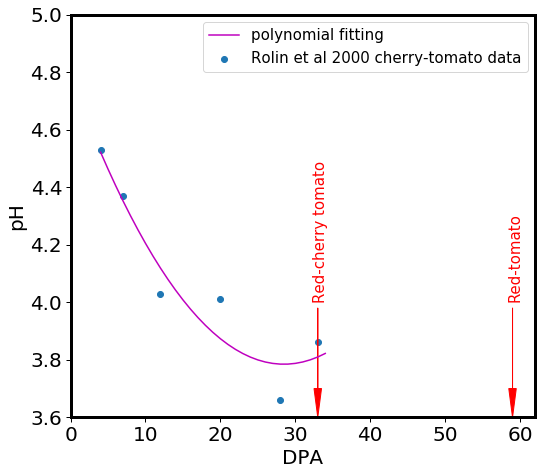

In [12]:
from pandas import DataFrame
d = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
pd = DataFrame(data = d)

import numpy as np
p = np.polyfit(d["DPA"],d["pH"],2)
q = np.poly1d(p)
#print(p)

x1=list()
y1=list()
y2=list()
for i in range(4,35):
    x1.append(i)
    y2.append(q(i))

    
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth']=3 # makes axes line thicker
plt.figure(figsize=(8,7))

plt.scatter(d["DPA"],d["pH"],label="Rolin et al 2000 cherry-tomato data")
plt.plot(x1,y2,label="polynomial fitting",color="m")
plt.text(32.3,4.45,"Red-cherry tomato",fontsize=15,color="r",rotation=90)
plt.arrow(33,3.98,0,-0.28,head_width=1,head_length=0.1,color="r")
plt.text(58.3,4.27,"Red-tomato",fontsize=15,color="r",rotation=90)
plt.arrow(59,3.98,0,-0.28,head_width=1,head_length=0.1,color="r")
plt.xlim(0,62)
plt.ylim(3.6,5.0)
plt.ylabel("pH")
plt.xlabel("DPA")
plt.legend(fontsize="15")
plt.tight_layout()
plt.show()


VacpH = dict()
compH = dict()
i=1
for x in DPA[1:]:
    VacpH[x]=round(q(x),1)
    compH["v"+str(i)]=round(q(x),1)
    i=i+1

Linear transformation of cherry tomato data to estiamte tomato DPA

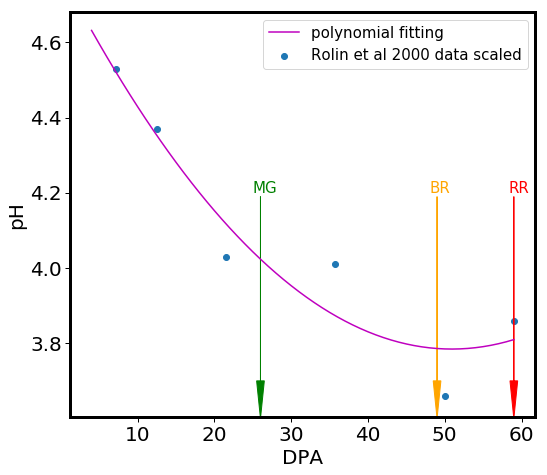

In [13]:
from pandas import DataFrame
d = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
d2 = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
for x in range(0,len(d["DPA"])):
    d2["DPA"][x]=round(d["DPA"][x]*(59.0/33),2)

pd = DataFrame(data = d2)

import numpy as np
p = np.polyfit(d2["DPA"],d2["pH"],2)
q = np.poly1d(p)

x1=list()
y1=list()
y2=list()
for i in range(4,60):
    x1.append(i)
    y2.append(q(i))

    
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth']=3 # makes axes line thicker
plt.figure(figsize=(8,7))

plt.scatter(d2["DPA"],d2["pH"],label="Rolin et al 2000 data scaled")
plt.plot(x1,y2,label="polynomial fitting",color="m")
plt.text(25,4.2,"MG",fontsize=15,color="g")
plt.arrow(26,4.19,0,-0.49,head_width=1,head_length=0.1,color="g")
plt.text(48,4.2,"BR",fontsize=15,color="orange")
plt.arrow(49,4.19,0,-0.49,head_width=1,head_length=0.1,color="orange")
plt.text(58.3,4.2,"RR",fontsize=15,color="r")
plt.arrow(59,4.19,0,-0.49,head_width=1,head_length=0.1,color="r")
plt.ylabel("pH")
plt.xlabel("DPA")
plt.legend(fontsize="15",loc="best")
plt.tight_layout()
plt.show()


VacpH = dict()
compH = dict()
i=1
for x in DPA[1:]:
    VacpH[x]=round(q(x),1)
    compH["v"+str(i)]=round(q(x),1)
    i=i+1
#d

### Setting up final biomass before updating vacuolar pH

In [14]:

AA_b = ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]

for m in AA_b:
    met = Metabolite(m+"_b10")
    met.compartment = "b10"
    met.name = cobra_model2.metabolites.get_by_id(m+"_c10").name
    met.formula = cobra_model2.metabolites.get_by_id(m+"_c10").formula
    met.notes = cobra_model2.metabolites.get_by_id(m+"_c10").notes
    met.charge = cobra_model2.metabolites.get_by_id(m+"_c10").charge
    rxn = Reaction("Biomass_"+m+"_c_tx10")
    rxn.name="Biomass "+m+" _c accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_c10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    rxn = Reaction("Biomass_"+m+"_v_tx10")
    rxn.name="Biomass "+m+" _v accumulation"
    cobra_model2.add_reaction(rxn)
    if m == "HIS":
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id("b"+m+"_v10"):-1,met:1})
    else:
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_v10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    
OA = ["CIT","MAL","FUM"]
for m in OA:
    met = Metabolite(m+"_b10")
    met.compartment = "b10"
    met.name = cobra_model2.metabolites.get_by_id(m+"_c10").name
    met.formula = cobra_model2.metabolites.get_by_id(m+"_c10").formula
    met.notes = cobra_model2.metabolites.get_by_id(m+"_c10").notes
    met.charge = cobra_model2.metabolites.get_by_id(m+"_c10").charge
    rxn = Reaction("Biomass_"+m+"_c_tx10")
    rxn.name="Biomass "+m+" _c accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_c10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    rxn = Reaction("Biomass_"+m+"_v_tx10")
    rxn.name="Biomass "+m+" _v accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_v10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000


Sugars = ["GLC","FRU","SUCROSE"]
for m in Sugars:
    met = Metabolite(m+"_b10")
    met.compartment = "b10"
    met.name = cobra_model2.metabolites.get_by_id(m+"_c10").name
    met.formula = cobra_model2.metabolites.get_by_id(m+"_c10").formula
    met.notes = cobra_model2.metabolites.get_by_id(m+"_c10").notes
    met.charge = cobra_model2.metabolites.get_by_id(m+"_c10").charge
    rxn = Reaction("Biomass_"+m+"_c_tx10")
    rxn.name="Biomass "+m+" _c accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_c10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    rxn = Reaction("Biomass_"+m+"_v_tx10")
    rxn.name="Biomass "+m+" _v accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_v10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    #######
    #rxn = Reaction("HYPO_biomass"+m)
    #rxn.add_metabolites({met:-1})
    #rxn.lower_bound = 0
    #rxn.upper_bound = 10
    #cobra_model2.add_reaction(rxn)




rxn = Reaction("Final_Biomass_tx")
rxn.name = "Final Fruit Biomass"
for k in Conc.keys():
    if k=="AA":
        for i in AA_b:
            rxn.add_metabolites({cobra_model2.metabolites.get_by_id(i+"_b10"):-float(Conc.get(k)[10])/scale})
    elif k=="Protein":
        continue
    elif k=="NA":
        continue
    else:
        if k=="STARCH":
            rxn.add_metabolites({cobra_model2.metabolites.get_by_id("Starch_b10"):-float(Conc.get(k)[10])/scale})
        elif k=="CELLULOSE":
            continue
        elif k=="PALMITATE":
            continue
        #elif k=="FUM":
        #    continue
        #elif k=="Pi":
        #    continue
        else:
            rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_b10"):-float(Conc.get(k)[10])/scale})

rxn.lower_bound = 0
rxn.upper_bound = 1000
cobra_model2.add_reaction(rxn)

for i in range(1,11):
    rxn = Reaction("Protein_biomass_demand_tx"+str(i))
    rxn.name = "Protein in Biomass "+str(i)
    k="Protein"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("PROTEIN_b"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)

rxn = Reaction("Final_DNARNA_tx")
rxn.name = "Final NA in Biomass"
k="NA"
rxn.add_metabolites({cobra_model2.metabolites.get_by_id("RNA_b10"):-1,cobra_model2.metabolites.get_by_id("DNA_b10"):-1})
rxn.lower_bound = 0#float(Conc.get(k)[10])/scale
rxn.upper_bound = 0#float(Conc.get(k)[10])/scale
cobra_model2.add_reaction(rxn)


for i in range(10,11):
    rxn = Reaction("NITRATE_biomass"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("NITRATE_v"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    rxn = Reaction("MAL_biomass"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("MAL_v"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    rxn = Reaction("CIT_biomass"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("CIT_v"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    for met in ["CAII","KI","MGII","NITRATE"]:
        rxn = Reaction(met+"_biomass_c"+str(i))
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(met+"_c"+str(i)):-1})
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
        cobra_model2.add_reaction(rxn)




In [15]:
chargedFruit = convertToFractionalChargesFruit(cobra_model2,infile="MetaboliteChargedStates.xlsx",compH=compH)
chargedFruit.reactions.get_by_id("Final_Biomass_tx").objective_coefficient=1

In [16]:
chargedFruit.reactions.Phloem_uptake_tx1.reaction

'0.9603960396 PROTON_e1 --> 0.0022970297 4_AMINO_BUTYRATE_c1 + 0.0004186704 ARG_c1 + 0.0015049505 ASN_c1 + 0.0004186704 CYS_c1 + 0.0792079208 FRU_c1 + 0.0693069307 GLC_c1 + 0.0240792079 GLN_c1 + 0.0124356436 GLT_c1 + 0.0007128713 GLY_c1 + 0.0004186704 HIS_c1 + 0.0017425743 ILE_c1 + 0.0020594059 LEU_c1 + 0.0022178218 LYS_c1 + 0.0038811881 L_ALPHA_ALANINE_c1 + 0.006019802 L_ASPARTATE_c1 + 0.0004186704 MET_c1 + 0.0057029703 PHE_c1 + 0.9603960396 PROTON_c1 + 0.0004186704 PRO_c1 + 0.003960396 SER_c1 + 0.7326732673 SUCROSE_c1 + 0.0068910891 THR_c1 + 0.0004186704 TRP_c1 + 0.0004186704 TYR_c1 + 0.0027722772 VAL_c1'

In [17]:
#removed LEU and TRP from phloem because degradation pathway is incomplete and their fraction in 
# phloem is extremely minor
for Met in ["LEU_c","TRP_c","VAL_c","ILE_c","PHE_c","4_AMINO_BUTYRATE_c","TYR_c","GLN_c"]:
    for i in range(1,11):
        met = chargedFruit.metabolites.get_by_id(Met+str(i))
        coeff = chargedFruit.reactions.get_by_id("Phloem_uptake_tx"+str(i)).metabolites.get(met)
        chargedFruit.reactions.get_by_id("Phloem_uptake_tx"+str(i)).add_metabolites({met:-1*coeff})

sol = chargedFruit.optimize()
sol.x_dict.get("Final_Biomass_tx")

233.65614542592633

### Constraining cellulose demand flux based on increasing cell volume

In [18]:
from studyFunctions import celluloseDemandFlux

cobra_model2 = chargedFruit.copy()
print("Constraining cellulose demand flux...")


for i in range(1,11):
    rxn = Reaction("CELLULOSE_accumulation"+str(i))
    met = cobra_model2.metabolites.get_by_id("CELLULOSE_c"+str(i))
    rxn.add_metabolites({met:-1})
    rxn.lower_bound = celluloseDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time)
    rxn.upper_bound = celluloseDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time)
    cobra_model2.add_reaction(rxn)


Constraining cellulose demand flux...


### Constraining palmitate demand flux based on increasing cell volume


In [19]:
from studyFunctions import phospholipidDemandFlux

print("Constraining phospholipid demand flux...")

for i in range(1,11):
    rxn = Reaction("phospholipid_accumulation"+str(i))
    met = cobra_model2.metabolites.get_by_id("L_1_PHOSPHATIDYL_ETHANOLAMINE_r"+str(i))
    rxn.add_metabolites({met:-0.273})
    met = cobra_model2.metabolites.get_by_id("PHOSPHATIDYL_CHOLINE_r"+str(i))
    rxn.add_metabolites({met:-0.353})
    met = cobra_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p"+str(i))
    rxn.add_metabolites({met:-0.374})
    rxn.lower_bound = float(phospholipidDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time,scaling_factor=100.0/8.512820512820287))
    rxn.upper_bound = float(phospholipidDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time,scaling_factor=100.0/8.512820512820287))
    cobra_model2.add_reaction(rxn)

Constraining phospholipid demand flux...


In [20]:
sol = cobra_model2.optimize()
sol.x_dict.get("Final_Biomass_tx")

233.65614542592633

### Constraining protein demand flux based on increasing cell volume


In [21]:
ProtConc=21458.1747597         #Biais data
#ProtConc=19659.7704473         #Jose's data

In [22]:
from studyFunctions import estimateProteinDemandFlux

print("Constraining protein demand flux...")
#cobra_model2 = temp_model.copy()
for i in range(1,11):
    rxn = cobra_model2.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    print(estimateProteinDemandFlux(DPA[i],ProtConc=21458.1747597,unit_time=unit_time,Ncell = 25*(10**6)))
    temp_A = estimateProteinDemandFlux(DPA[i],ProtConc=21458.1747597,unit_time=unit_time,Ncell = 25*(10**6))
    rxn.lower_bound = temp_A
    rxn.upper_bound = temp_A
    



Constraining protein demand flux...
0.0112816633773
0.0174385732478
0.0259973905035
0.030016941082
0.0237650500464
0.013162547312
0.00567001934018
0.00208064699906
0.000668913450129
0.000176835351992


In [23]:
sol = cobra_model2.optimize()
print(sol.f)

2.64816625885


### Phytol and Lycopene data

In [24]:
#constraining pigment accumulation/degradation rates
for i in range(1,11):
    rxn = Reaction("Lycopene_biomass_demand_tx"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("CPD1F_114_p"+str(i)):-1})
    rxn.lower_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)    #mmol/fruit/5.1day
    rxn.upper_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)    #mmol/fruit/5.1day
    #print(rxn.reaction)
    print(rxn.lower_bound)
    cobra_model2.add_reaction(rxn)
    
    rxn = Reaction("Phytol_biomass_demand_tx"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("PHYTOL_p"+str(i)):-1})
    rxn.lower_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day
    rxn.upper_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day
    #print rxn.lower_bound
    cobra_model2.add_reaction(rxn)

2.49659137808e-12
9.47693877151e-10
8.15478226563e-08
2.8662259526e-06
5.49617628915e-05
0.000632356115311
0.00308416828079
0.0031979747548
0.000873216062261
0.000160538104002


In [25]:
sol=cobra_model2.optimize()
print(sol.f)

2.64118412361


### checkpoint : create backup

In [26]:
backup2 =  cobra_model2.copy()

### Add osmotic constraint to fruit model


In [27]:
cobra_model2 = backup2.copy()


vacMets=["SUCROSE_v","MAL_v","NITRATE_v","AMMONIUM_v","CIT_v","GLN_v","ASN_v","SER_v","GLY_v","THR_v","L_ALPHA_ALANINE_v","4_AMINO_BUTYRATE_v","VAL_v","ILE_v","PHE_v","LEU_v","LYS_v","ARG_v","L_ASPARTATE_v","GLT_v","bHIS_v","MET_v","PRO_v","TRP_v","TYR_v","CYS_v","GLC_v","FRU_v","FUM_v","MGII_v","KI_v","CAII_v"]


#Add water potential constraint on the whole cell
for i in range(1,10):
    met1_v = Metabolite("VO_"+str(i))
    met1_v.name = "vacuolar osmolarity pseudo metabolite"
    met1_c = Metabolite("CO_"+str(i))
    met1_c.name = "cytosolic osmolarity pseudo metabolite"
    met2_c = Metabolite("CC_c"+str(i))
    met2_c.name = "cytosolic_charge_constraint"
    met2_c.compartment="c"+str(i)
    met2_v = Metabolite("CC_v"+str(i))
    met2_v.name = "vacuolar_charge_constraint"
    met2_v.compartment="v"+str(i)
    for metID in vacMets:
        met = cobra_model2.metabolites.get_by_id(metID+str(i))
        rxn = cobra_model2.reactions.get_by_id(metID+"_Transfer"+str(i)+str(i+1))
        charge = 0
        for Reac in rxn.reactants:
            if Reac.id.__contains__("PROTON"):
                continue
            charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        rxn.add_metabolites({met1_v:1,met2_v:charge})
    for rxn in cobra_model2.reactions.query("_c_Transfer"+str(i)+str(i+1)):
        charge = 0
        for Reac in rxn.reactants:
            if Reac.id.__contains__("PROTON"):
                continue
            charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        rxn.add_metabolites({met1_c:1,met2_c:charge})




#Set constraints for final fruit biomass
met1_v = Metabolite("VO_10")
met1_v.name = "vacuolar osmolarity pseudo metabolite"
met1_c = Metabolite("CO_10")
met1_c.name = "cytosolic osmolarity pseudo metabolite"
met2_c = Metabolite("CC_c10")
met2_c.name = "cytosolic_charge_constraint"
met2_c.compartment="c10"
met2_v = Metabolite("CC_v10")
met2_v.name = "vacuolar_charge_constraint"
met2_v.compartment="v10"

VO_10 = 0
CO_10 = 0
CC_c10 = 0
CC_v10 = 0

AA_b = ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]

for m in AA_b:
    met = cobra_model2.metabolites.get_by_id(m+"_c10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_c_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_c:stoich,met2_c:charge})
    met = cobra_model2.metabolites.get_by_id(m+"_v10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_v_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_v:stoich,met2_v:charge})

    
OA = ["CIT","MAL"]

for m in OA:
    met = cobra_model2.metabolites.get_by_id(m+"_c10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_c_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_c:stoich,met2_c:charge})
    met = cobra_model2.metabolites.get_by_id(m+"_v10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_v_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_v:stoich,met2_v:charge})

Sugars = ["GLC","FRU","SUCROSE"]

for m in Sugars:
    met = cobra_model2.metabolites.get_by_id(m+"_c10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_c_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_c:stoich,met2_c:charge})
    met = cobra_model2.metabolites.get_by_id(m+"_v10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_v_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_v:stoich,met2_v:charge})


#
rxn = cobra_model2.reactions.get_by_id("Ca_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:2})
rxn = cobra_model2.reactions.get_by_id("Mg_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:2})
rxn = cobra_model2.reactions.get_by_id("K_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:1})
rxn = cobra_model2.reactions.get_by_id("NITRATE_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:-1})
rxn = cobra_model2.reactions.get_by_id("CAII_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:2})
rxn = cobra_model2.reactions.get_by_id("MGII_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:2})
rxn = cobra_model2.reactions.get_by_id("KI_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:1})
rxn = cobra_model2.reactions.get_by_id("NITRATE_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:-1})


import math
#Set total(met1_v) = (volume_of_vacuole/volume_of_cytosol) * total(met1_c)
for i in range(1,11):
    Vv = 0.853*(1-(math.e**((-2293-(DPA[i]*24*60))/10633)))
    Vc = (0.933 - Vv)/1.13
    #print(Vv/Vc)
    met = Metabolite("WCO_"+str(i))
    met.name = "Whole cell osmolarity psuedo metabolite"
    met1_v = cobra_model2.metabolites.get_by_id("VO_"+str(i))
    met1_c = cobra_model2.metabolites.get_by_id("CO_"+str(i))
    rxn =Reaction("IntercellularWaterPotentialConstraint"+str(i))
    rxn.add_metabolites({met1_c:-1,met1_v:-1*(Vv/Vc),met:1+(Vv/Vc)})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)

        
#Set sum(van't_Hoff_factor*number_of_moles) = cell_volume*Osmolarity
import math
C_cell = 275           #Almeida and Huber 1999; units = mOsmol/kg ~ mmol/L
C_cell = 275000        #units = mmol/m3
for i in range(1,11):
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    V_pericarp = estimateVpericarp(DPA[i],hollow=False)
    rxn = Reaction("WCOsetter_tx"+str(i))
    rxn.name = "WCO_setter"
    rxn.add_metabolites({met:-1})
    rxn.lower_bound = round(V_pericarp*C_cell,3)
    rxn.upper_bound = round(V_pericarp*C_cell,3)
    cobra_model2.add_reaction(rxn)



In [28]:
sol=cobra_model2.optimize()

### Accounting for NGAM  based on maintenance respiration in Walker and Thornley 1997



In [29]:
mR ={387:0.052,931:0.021,1591:0.015,2402:0.007}
for i in mR.keys():
    print("==========")
    print("mass ="+str(i))
    print("relative r="+str(mR[i]))
    print("mg/day ="+str(mR[i]*i))
    print("mmol/day ="+str(mR[i]*i/12))
    print("mmol/day ="+str(mR[i]*i*unit_time/12))

mass =2402
relative r=0.007
mg/day =16.814
mmol/day =1.40116666667
mmol/day =7.14595
mass =387
relative r=0.052
mg/day =20.124
mmol/day =1.677
mmol/day =8.5527
mass =931
relative r=0.021
mg/day =19.551
mmol/day =1.62925
mmol/day =8.309175
mass =1591
relative r=0.015
mg/day =23.865
mmol/day =1.98875
mmol/day =10.142625


    This maitenance respiration is reported in relative respiration units. Converting them into mg/day, mmol/day and mmol/5.1 days:
    ================================================================================
    Mean fruit mass       1/day        mg/day          mmol/day         mmol/5.1days
    ================================================================================
      387                0.052          20.124           1.677             8.553
      931                0.021          19.551           1.629             8.308
     1591                0.015          23.865           1.989            10.144
     2402                0.007          16.814           1.401             7.145
    ================================================================================

In [30]:
meanRes = (8.553+8.308+10.144+7.145)/4
print(meanRes)

8.5375


    Using core model ATPase NGAM flux of 26.2 mmol/fruit/5.1 days was estimated to correspond with a respiration rate of 8.5375 mmol CO2/fruit/5.1

In [31]:
ATPase = 26.2

In [32]:
for i in range(1,11):
    met=Metabolite("ATPNAPDH_maintenance_constraint_"+str(i))
    cobra_model2.reactions.get_by_id("ATPase_tx"+str(i)).add_metabolites({met:-1})
    cobra_model2.reactions.get_by_id("NADPHoxc_tx"+str(i)).add_metabolites({met:3})
    cobra_model2.reactions.get_by_id("NADPHoxp_tx"+str(i)).add_metabolites({met:3})
    cobra_model2.reactions.get_by_id("NADPHoxm_tx"+str(i)).add_metabolites({met:3})
    cobra_model2.reactions.get_by_id("ATPase_tx"+str(i)).lower_bound = ATPase
    cobra_model2.reactions.get_by_id("ATPase_tx"+str(i)).upper_bound = ATPase


In [33]:
backup4 = cobra_model2.copy()
backup4.optimize()

<Solution 1.103 at 0x7f74fdbe11d0>

### Constraining phloem uptake rate

In [34]:

cobra_model2 = backup4.copy()
C=0
for met in cobra_model2.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if met.formula == "" or met.formula == "NA" or not "C" in met.formula:
        continue
    C=C+(int(met.formula.split("H")[0].split("C")[1])*cobra_model2.reactions.get_by_id("Phloem_uptake_tx1").metabolites.get(met))

print("Total C in 1 mol of phloem = "+str(abs(C)))
print("-------------")

for i in range(1,11):
    Ccont = estimateCcontent(DPA[i])
    cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = estimatePhloemUptakeConstraint(Ccont)*24*(unit_time/abs(C*12))
    print "Cuptake rate = "+str(estimatePhloemUptakeConstraint(Ccont)*24*(unit_time/abs(C*12)))


Total C in 1 mol of phloem = 9.8517340867
-------------
Cuptake rate = 10.3246788549
Cuptake rate = 9.85705699494
Cuptake rate = 7.10505745832
Cuptake rate = 4.09152557633
Cuptake rate = 3.17570829047
Cuptake rate = 2.97194127161
Cuptake rate = 2.92189127324
Cuptake rate = 2.90765364888
Cuptake rate = 2.90304441179
Cuptake rate = 2.90138312454


### g) Run basic simulation

In [35]:
for i in range(1,10):
    rxn = cobra_model2.reactions.get_by_id("FUM_c_Transfer"+str(i)+str(i+1))
    rxn.lower_bound = rxn.upper_bound = 0
    rxn = cobra_model2.reactions.get_by_id("FUM_v_Transfer"+str(i)+str(i+1))
    rxn.lower_bound = rxn.upper_bound = 0
    #set Lycopene and Phytol demand to 0
    rxn = cobra_model2.reactions.get_by_id("Lycopene_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = Reaction("Phytol_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0



In [36]:
weightings =dict()
for rxn in cobra_model2.reactions:
    if rxn.id.__contains__("Transfer"):
        weightings[rxn.id]=1
    elif rxn.id.__contains__("Photon_") or rxn.id.startswith("H_") or rxn.id.__contains__("H2O_") or rxn.id.__contains__("O2_") or rxn.id.__contains__("CO2_"):
        weightings[rxn.id]=1
    else:
        weightings[rxn.id]=1

In [37]:
import time
print(time.ctime())
cobra_model2.reactions.get_by_id("Final_Biomass_tx").objective_coefficient=1
cobra_model2.solver="cplex"
#solution2 = flux_analysis.parsimonious.pfba(cobra_model2)
solution = pfba_Weighted(cobra_model2,weightings)
print(time.ctime())

Fri Aug  9 16:02:17 2019
Fri Aug  9 16:02:37 2019


### Fruit final biomass

In [38]:
print("Final fruit biomass accumulation flux for model with osmolarity constraint = "+str(solution.x_dict["Final_Biomass_tx"]))

cobra_model3 = cobra_model2.copy()
for i in range(1,11):
    cobra_model3.metabolites.get_by_id("VO_"+str(i)).remove_from_model()
    cobra_model3.metabolites.get_by_id("CO_"+str(i)).remove_from_model()
    cobra_model3.metabolites.get_by_id("WCO_"+str(i)).remove_from_model()
solution3 = cobra_model3.optimize()
#solution3 = pfba_Weighted(cobra_model3,weightings)
print("Final fruit biomass accumulation flux for model without osmolarity constraint = "+str(solution3.x_dict["Final_Biomass_tx"]))

Final fruit biomass accumulation flux for model with osmolarity constraint = 1.1026173081545576
Final fruit biomass accumulation flux for model without osmolarity constraint = 1.4369743903891405


### Export model

In [42]:
temp_model = cobra_model2.copy()
for met in temp_model.metabolites:
    if met.charge != None:
        met.charge = int(met.charge)
io.sbml.write_cobra_model_to_sbml_file(temp_model,"ConstrainedFruitModel.xml",use_fbc_package=False)

# Validating the fruit model's metabolic content

In [43]:
from studyFunctions import generateBoundsFromBiomass


#Day time points of interest
DPA = list(np.linspace(8,59,11))

mets = ("GLC","FRU","SUC","MAL","CIT","L_ALPHA_ALANINE","ASN","L_ASPARTATE","GABA","GLT",
        "GLN","GLY","ILE","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL","Pi","FUM")
dfile="Data_OrganicSolutes.csv"
Nsampl= 1000
Ssampl= 0.80

Conc = dict()
Conc_max = dict()
Conc_min = dict()
flux_max = dict()
flux_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [Conc[met],Conc_max[met],Conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,
                                                                                                met=met,
                                                                                                Nsampling=Nsampl,
                                                                                                DPA=DPA,
                                                                                                show_plots=False,
                                                                                                degree=3,
                                                                                                Ssampling=Ssampl,
                                                                                                start=8,stop=59)

mets = ("STARCH",)
dfile="Data_Starch_Protein.csv"

for met in mets:
  print "Processing "+met+"..."
  [Conc[met],Conc_max[met],Conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,
                                                                                                met=met,
                                                                                                Nsampling=Nsampl,
                                                                                                DPA=DPA,
                                                                                                show_plots=False,
                                                                                                degree=3,
                                                                                                Ssampling=Ssampl,
                                                                                                start=8,stop=59)


Processing GLC...
Processing FRU...
Processing SUC...
Processing MAL...
Processing CIT...
Processing L_ALPHA_ALANINE...
Processing ASN...
Processing L_ASPARTATE...
Processing GABA...
Processing GLT...
Processing GLN...
Processing GLY...
Processing ILE...
Processing LYS...
Processing MET...
Processing PHE...
Processing PRO...
Processing SER...
Processing THR...
Processing TRP...
Processing TYR...
Processing VAL...
Processing Pi...
Processing FUM...
Processing STARCH...


In [44]:
Conc["SUCROSE"]=Conc["SUC"]
del Conc["SUC"]
del Conc["Pi"]

In [45]:
Conc["4_AMINO_BUTYRATE"]=Conc["GABA"]
del Conc["GABA"]

In [46]:
Conc_max["SUCROSE"]=Conc_max["SUC"]
del Conc_max["SUC"]
del Conc_max["Pi"]
Conc_max["4_AMINO_BUTYRATE"]=Conc_max["GABA"]
del Conc_max["GABA"]

In [47]:
Conc_min["SUCROSE"]=Conc_min["SUC"]
del Conc_min["SUC"]
del Conc_min["Pi"]
Conc_min["4_AMINO_BUTYRATE"]=Conc_min["GABA"]
del Conc_min["GABA"]

In [48]:
for k in Conc.keys():
    for i in range(1,10):
        if k != "STARCH":
            met = Metabolite(k+str(i))
            rxn = cobra_model2.reactions.get_by_id(k+"_c_Transfer"+str(i)+str(i+1))
            rxn.add_metabolites({met:1})
            rxn = cobra_model2.reactions.get_by_id(k+"_v_Transfer"+str(i)+str(i+1))
            rxn.add_metabolites({met:1})
            rxn=Reaction(k+"_signal"+str(i))
            rxn.add_metabolites({met:-1})
            rxn.lower_bound = 0
            rxn.upper_bound = 1000
            cobra_model2.add_reaction(rxn)
            weightings[rxn.id]=0

solution2 = pfba_Weighted(cobra_model2,weightings)

In [49]:
from studyFunctions import FBA_FVA_run
cobra_model5 = FBA_FVA_run(cobra_model2,cobra_model2.reactions.get_by_id("Final_Biomass_tx"),
                           rxnlist = cobra_model2.reactions.query("_signal")+ \
                           cobra_model2.reactions.query("STARCH_p_Transfer"),
                           weightings=weightings)

Runing pFBA
Setting SOF model
Running FVA
Processing results


    Processing results...

In [50]:

xlist = list()
for i in range(1,11):
    i=i*20
    xlist.append(i)
barwidth = 6
xlist2 = list()
for i in range(1,11):
    i=i*20
    xlist2.append(round(i-barwidth,2))

metdict = dict()
maxdict = dict()
mindict = dict()
for met in Conc.keys():
    templist = list()
    maxlist=list()
    minlist=list()
    for i in range(1,10):
        if met != "STARCH":
            templist.append(solution2.x_dict.get(met+"_c_Transfer"+str(i)+str(i+1))+solution2.x_dict.get(met+"_v_Transfer"+str(i)+str(i+1)))
            maxlist.append(cobra_model5.fva["maximum"][met+"_signal"+str(i)])
            minlist.append(cobra_model5.fva["minimum"][met+"_signal"+str(i)])
        else:
            templist.append(solution2.x_dict.get(met+"_p_Transfer"+str(i)+str(i+1)))
            maxlist.append(cobra_model5.fva["maximum"][met+"_p_Transfer"+str(i)+str(i+1)])
            minlist.append(cobra_model5.fva["minimum"][met+"_p_Transfer"+str(i)+str(i+1)])
    if met != "STARCH":
        templist.append(abs(solution2.x_dict.get("Final_Biomass_tx")*cobra_model2.reactions.get_by_id("Final_Biomass_tx").metabolites.get(cobra_model2.metabolites.get_by_id(met+"_b10"))))
        maxlist.append(0)
        minlist.append(0)
    metdict[met]=templist
    maxdict[met]=maxlist
    mindict[met]=minlist



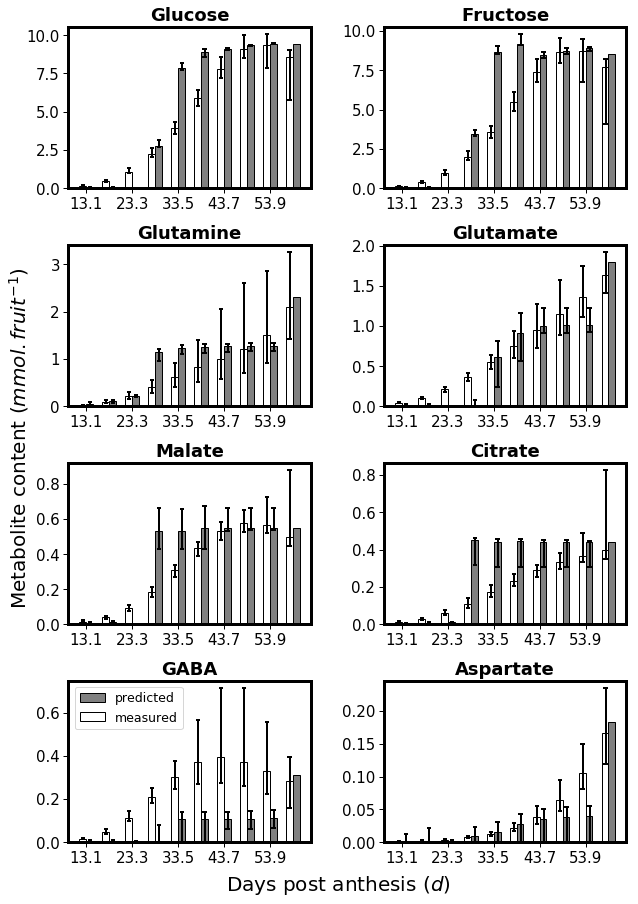

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,15))
titledict = {"GLC":"Glucose","FRU":"Fructose",
             "MAL":"Malate","CIT":"Citrate",
             "GLN":"Glutamine","GLT":"Glutamate",
             "4_AMINO_BUTYRATE":"GABA","L_ASPARTATE":"Aspartate"}
import string
alphabets = list(string.ascii_lowercase)

i=0
for met in ["GLC","FRU","GLN","GLT","MAL","CIT","4_AMINO_BUTYRATE","L_ASPARTATE"]:
    row = int(round(i/2))
    col = int(round(i%2))
    
    ax = axes[row,col]
    if met=="STARCH":
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",zorder=-1,label="predicted")
    else:
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",edgecolor="black",zorder=-1,label="predicted")
    
    offset2 = 0
    if col == 1:
        offset2 = 1
    for k in range(0,len(xlist)):
        ax.plot([xlist[k]+offset2,xlist[k]+offset2],[maxdict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[mindict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[maxdict[met][k],maxdict[met][k]],color="black",linewidth=2)
    ax.bar(xlist2,Conc[met][1:],width=barwidth,color="white",edgecolor="black",zorder=1,label="measured")
    for k in range(0,len(xlist2)):
        ax.plot([xlist2[k]+offset2,xlist2[k]+offset2],[Conc_max[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_max[met][1:][k],Conc_max[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_min[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
    ax.set_title(titledict[met],fontweight="bold")
    offset = float(barwidth)/2
    ax.set_xticks([round(xlist[0]-offset,2),round(xlist[2]-offset,2),round(xlist[4]-offset,2),round(xlist[6]-offset,2),round(xlist[8]-offset,2)])
    ax.set_xticklabels([round(DPA[1],1),round(DPA[3],1),round(DPA[5],1),round(DPA[7],1),round(DPA[9],1)])
    
    if met == "4_AMINO_BUTYRATE":
        ax.legend(loc="upper left",fontsize = 12.5)
    
    i=i+1
for j in range(i,8):
    row = int(round(j/2))
    col = int(round(j%2))
    ax = axes[row,col]
    ax.set_visible(False)
plt.subplots_adjust(wspace = 0.3,hspace=0.35)
fig.text(0.5, 0.08, 'Days post anthesis ($d$)', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Metabolite content ($mmol.fruit^{-1}$)', va='center', rotation='vertical', fontsize=20)
plt.savefig("Figure6.png")


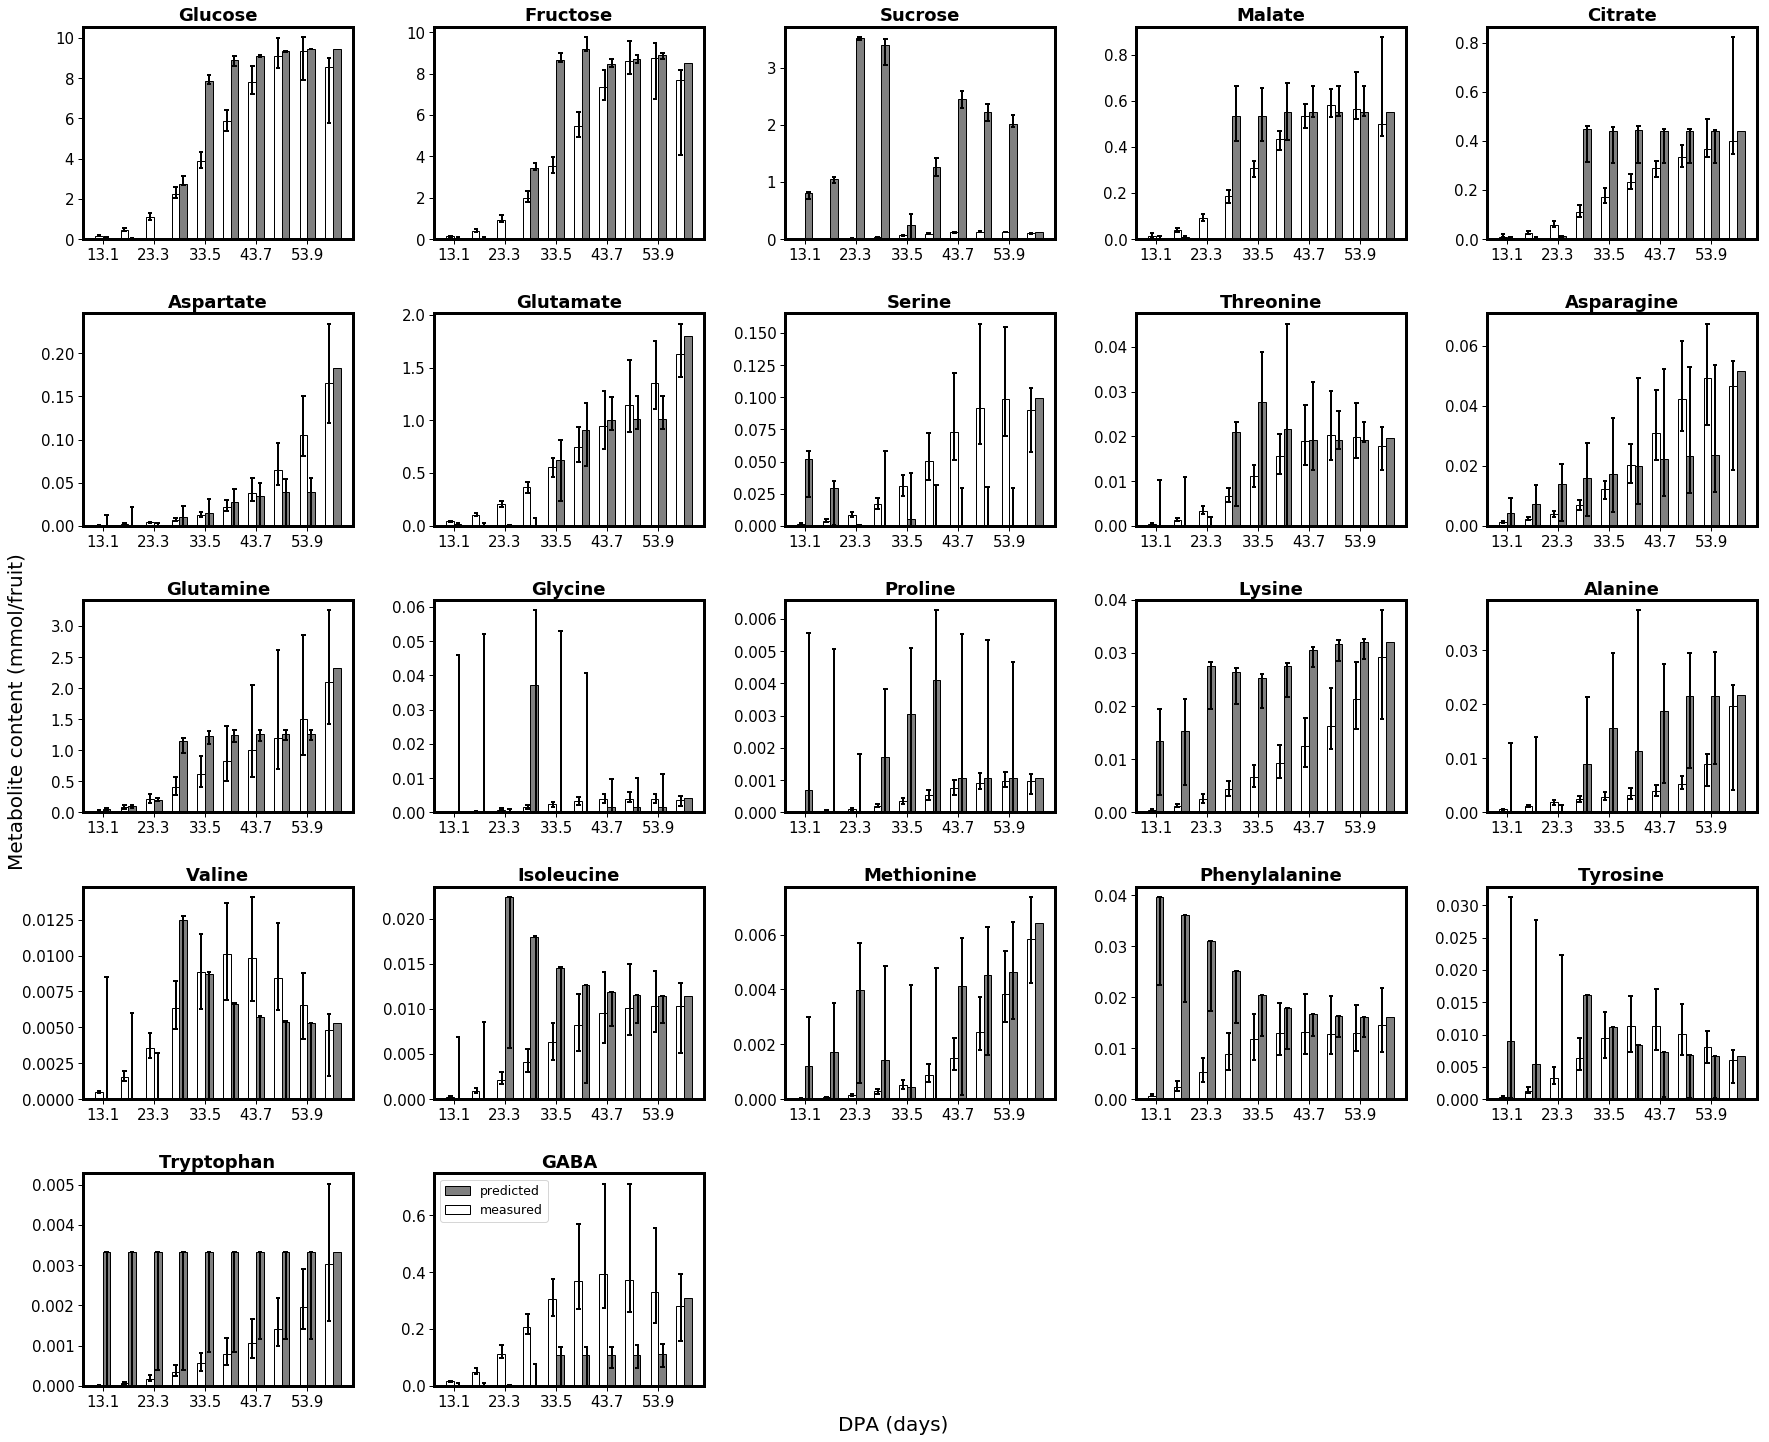

In [56]:
xlist3 = list()
for x in xlist:
    xlist3.append(x-7)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(30,25))
titledict = {"GLC":"Glucose","FRU":"Fructose","SUCROSE":"Sucrose","MAL":"Malate",
             "CIT":"Citrate","GLN":"Glutamine","GLT":"Glutamate","4_AMINO_BUTYRATE":"GABA",
             "L_ASPARTATE":"Aspartate","SER":"Serine","THR":"Threonine","ASN":"Asparagine",
             "GLY":"Glycine","PRO":"Proline","LYS":"Lysine","L_ALPHA_ALANINE":"Alanine",
             "VAL":"Valine","ILE":"Isoleucine","MET":"Methionine","PHE":"Phenylalanine",
             "TYR":"Tyrosine","TRP":"Tryptophan"}
import string
alphabets = list(string.ascii_lowercase)

i=0
for met in ["GLC","FRU","SUCROSE","MAL","CIT","L_ASPARTATE","GLT","SER","THR","ASN","GLN",
            "GLY","PRO","LYS","L_ALPHA_ALANINE","VAL","ILE","MET","PHE","TYR","TRP","4_AMINO_BUTYRATE"]:
    row = int(round(i/5))
    col = int(round(i%5))
    
    ax = axes[row,col]
    if met=="STARCH":
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",zorder=-1,label="predicted")
    else:
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",edgecolor="black",zorder=-1,label="predicted")
    
    offset2 = 0
    if col == 1:
        offset2 = 1
    for k in range(0,len(xlist)):
        ax.plot([xlist[k]+offset2,xlist[k]+offset2],[maxdict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[mindict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[maxdict[met][k],maxdict[met][k]],color="black",linewidth=2)
    ax.bar(xlist2,Conc[met][1:],width=barwidth,color="white",edgecolor="black",zorder=1,label="measured")
    for k in range(0,len(xlist2)):
        ax.plot([xlist2[k]+offset2,xlist2[k]+offset2],[Conc_max[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_max[met][1:][k],Conc_max[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_min[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
    ax.set_title(titledict[met],fontweight="bold")
    offset = float(barwidth)/2
    ax.set_xticks([round(xlist[0]-offset,2),round(xlist[2]-offset,2),round(xlist[4]-offset,2),round(xlist[6]-offset,2),round(xlist[8]-offset,2)])
    ax.set_xticklabels([round(DPA[1],1),round(DPA[3],1),round(DPA[5],1),round(DPA[7],1),round(DPA[9],1)])
    
    if met == "4_AMINO_BUTYRATE":
        ax.legend(loc="upper left",fontsize = 12.5)
    
    i=i+1
for j in range(i,25):
    row = int(round(j/5))
    col = int(round(j%5))
    ax = axes[row,col]
    ax.set_visible(False)
plt.subplots_adjust(wspace = 0.3,hspace=0.35)
fig.text(0.5, 0.1, 'DPA (days)', ha='center', fontsize=20)
fig.text(0.09, 0.5, 'Metabolite content (mmol/fruit)', va='center', rotation='vertical', fontsize=20)
plt.savefig("FigureS1.svg",format="svg")
plt.legend()
plt.show()

### Numbers of osmoles vs biomass

In [60]:
#Day time points of interest
DPA = list(np.linspace(8,59,11))

xlist = list()
ylist = list()
ylist2= list()
ylist3= list()
ylist4= list()
ylist5= list()
for i in range(1,10):
    xlist.append(i)
    ylist.append(celluloseLevels(DPA[i],Ncells = 25*(10**6)) * 180.16)
    ylist2.append(phospholipidLevels(DPA[i],Ncells = 25*(10**6),scaling_factor=100.0/8.512820512820287)*689.978637415773)
    ylist3.append(estimateProteinContent(DPA[i],ProtConc=21458.1747597,Ncell = 25*(10**6)) * 461.181100469)
    temp = 0
    temp2=0
    if i == 1:
        TEMP=0
        for rxn in cobra_model2.reactions.query("Initial"):
            for met in rxn.products:
                if not("CC" in met.id or "VC" in met.id or "CO" in met.id or "VO" in met.id or "PROTON" in met.id):
                    TEMP=TEMP+(met.formula_weight*solution2.x_dict.get(rxn.id))
    for rxn in cobra_model2.reactions.query("Transfer"+str(i)+str(i+1)):
        for met in rxn.reactants:
            if not("CC" in met.id or "VC" in met.id or "CO" in met.id or "VO" in met.id or "PROTON" in met.id):
                temp=temp+(met.formula_weight*solution2.x_dict.get(rxn.id))
                
    ylist4.append(temp)
    TEMP=temp
    if i == 1:
        TEMP2 = solution2.x_dict.get("Initial_STARCH_tx")*cobra_model2.metabolites.STARCH_p1.formula_weight
    temp2 = solution2.x_dict.get("STARCH_p_Transfer"+str(i)+str(i+1))*cobra_model2.metabolites.STARCH_p1.formula_weight
    ylist5.append(temp2)
    TEMP2 = temp2
    

ylist6=list()
for i in range(0,len(ylist5)):
    ylist6.append(ylist[i]+ylist2[i]+ylist3[i]+ylist4[i]+ylist5[i])


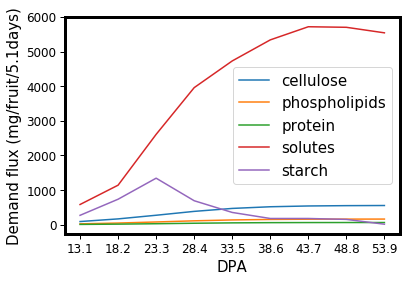

In [61]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

plt.xlabel("DPA")
plt.xticks(xlist,DPA[1:],fontsize=12)
plt.ylabel("Demand flux (mg/fruit/5.1days)")
plt.yticks(fontsize=12)
plt.plot(xlist,ylist,label="cellulose")
plt.plot(xlist,ylist2,label="phospholipids")
plt.plot(xlist,ylist3,label="protein")
plt.plot(xlist,ylist4,label="solutes")
plt.plot(xlist,ylist5,label="starch")
plt.legend(loc="best")

In [62]:
import pandas as pd
df3 = pd.DataFrame(data={"Phase":xlist,"cellulose":ylist,"phospholipids":ylist2,"protein":ylist3,"starch":ylist5,"solutes":ylist4,"total":ylist6})
df3

,Phase,cellulose,phospholipids,protein,solutes,starch,total
0,1,94.226241,27.939999,11.268824,585.881044,273.600068,992.916176
1,2,170.620394,50.634839,19.311164,1143.525464,738.311107,2122.402968
2,3,275.767896,81.881697,31.300670,2610.090986,1345.449730,4344.490980
3,4,387.488764,115.088436,45.143915,3958.056614,694.653239,5200.430969
4,5,472.679631,140.412413,56.103907,4728.608156,356.834501,5754.638608
5,6,520.922931,154.754066,62.174225,5336.167875,182.552444,6256.571542
6,7,543.440581,161.448221,64.789131,5715.371626,182.552444,6667.602003
7,8,552.962310,164.278916,65.748686,5699.335853,156.100618,6638.426383
8,9,556.816243,165.424648,66.057177,5539.751196,17.280021,6345.329285


In [63]:
y2list = list()
y2list2 = list()
y2list3 = list()
y2list4 = list()
y2list5 = list()
y2list6 = list()
for i in range(0,len(ylist)):
    y2list.append(round(100*ylist[i]/ylist6[i],2))
    y2list2.append(round(100*ylist2[i]/ylist6[i],2))
    y2list3.append(round(100*ylist3[i]/ylist6[i],2))
    y2list4.append(round(100*ylist4[i]/ylist6[i],2))
    y2list5.append(round(100*ylist5[i]/ylist6[i],2))

df4 = pd.DataFrame(data={"Phase":xlist,"cellulose":y2list,"phospholipids":y2list2,"protein":y2list3,"starch":y2list5,"solutes":y2list4,"total":ylist6})
df4

,Phase,cellulose,phospholipids,protein,solutes,starch,total
0,1,9.49,2.81,1.13,59.01,27.56,992.916176
1,2,8.04,2.39,0.91,53.88,34.79,2122.402968
2,3,6.35,1.88,0.72,60.08,30.97,4344.490980
3,4,7.45,2.21,0.87,76.11,13.36,5200.430969
4,5,8.21,2.44,0.97,82.17,6.20,5754.638608
5,6,8.33,2.47,0.99,85.29,2.92,6256.571542
6,7,8.15,2.42,0.97,85.72,2.74,6667.602003
7,8,8.33,2.47,0.99,85.85,2.35,6638.426383
8,9,8.78,2.61,1.04,87.30,0.27,6345.329285


#### Plot sucrose, starch in default, no phloem and no starch accumulation

In [64]:


rxnlist= list()
for i in range(2,11):
    for met in ["STARCH_p_Transfer"]:
        rxnlist.append(cobra_model2.reactions.get_by_id(met+str(i-1)+str(i)))
for i in range(1,10):
    for rxn in ["Phloem_uptake_tx","SUCROSE_signal","GLC_signal","FRU_signal"]:
        rxnlist.append(cobra_model2.reactions.get_by_id(rxn+str(i)))

        

cobra_model3 = cobra_model2.copy()

for i in range(1,11):
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000

temp_solution = pfba_Weighted(cobra_model3,weightings)       


rxnlist2= list()
for i in range(2,11):
    for met in ["STARCH_p_Transfer"]:
        rxnlist2.append(cobra_model3.reactions.get_by_id(met+str(i-1)+str(i)))
for i in range(1,10):
    for rxn in ["Phloem_uptake_tx","SUCROSE_signal","GLC_signal","FRU_signal"]:
        rxnlist2.append(cobra_model3.reactions.get_by_id(rxn+str(i)))
        

cobra_model4 = cobra_model2.copy()

for i in range(1,10):
    cobra_model4.reactions.get_by_id("STARCH_p_Transfer"+str(i)+str(i+1)).lower_bound = 0
    cobra_model4.reactions.get_by_id("STARCH_p_Transfer"+str(i)+str(i+1)).upper_bound = 0

temp_solution2 = pfba_Weighted(cobra_model4,weightings)       


rxnlist3= list()
for i in range(2,11):
    for met in ["STARCH_p_Transfer"]:
        rxnlist3.append(cobra_model4.reactions.get_by_id(met+str(i-1)+str(i)))
for i in range(1,10):
    for rxn in ["Phloem_uptake_tx","SUCROSE_signal","GLC_signal","FRU_signal"]:
        rxnlist3.append(cobra_model4.reactions.get_by_id(rxn+str(i)))        

        
import time
print(time.ctime())
cobra_model6 = FBA_FVA_run(cobra_model2,cobra_model2.reactions.get_by_id("Final_Biomass_tx"),rxnlist = rxnlist, weightings=weightings)
cobra_model7 = FBA_FVA_run(cobra_model3,cobra_model3.reactions.get_by_id("Final_Biomass_tx"),rxnlist = rxnlist2, weightings=weightings)
cobra_model8 = FBA_FVA_run(cobra_model4,cobra_model4.reactions.get_by_id("Final_Biomass_tx"),rxnlist = rxnlist3, weightings=weightings)
print(time.ctime())

Thu Aug  8 14:31:10 2019
Runing pFBA
Setting SOF model
Running FVA
Processing results
Runing pFBA
Setting SOF model
Running FVA
Processing results
Runing pFBA
Setting SOF model
Running FVA
Processing results
Thu Aug  8 14:34:09 2019


In [65]:

import numpy as np
#Day time points of interest
DAA = list(np.linspace(8,59,11))

mets = ("STARCH",)
dfile="Data_Starch_Protein.csv"
Nsampl= 1000
Ssampl= 0.80

C_Jose = dict()
C_max_Jose = dict()
C_min_Jose = dict()
F_max = dict()
F_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [C_Jose[met],C_max_Jose[met],C_min_Jose[met],F_max[met],F_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=False,degree=3,Ssampling=Ssampl,start=8,stop=59)



Processing STARCH...


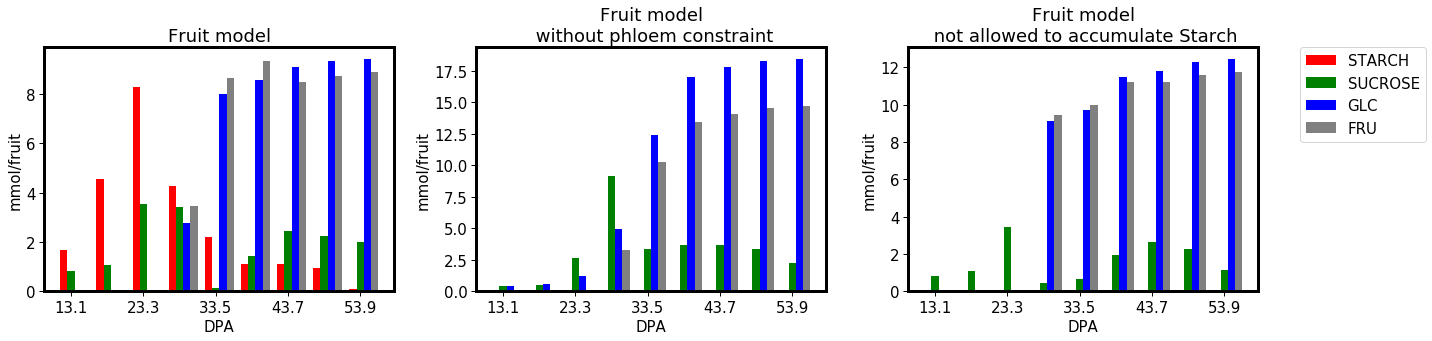

In [66]:


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))


ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
templist = list()
templistB = list()
templist2 = list()
templist2B = list()
templist3 = list()
templist3B = list()
templistC = list()
templistD = list()
templist2C = list()
templist2D = list()
templist3C = list()
templist3D = list()
xlist = list()
xlist2 = list()
xlist3 = list()
xlist4 = list()
xlist5 = list()
error_min = list()
error_max = list()
error_minB = list()
error_maxB = list()
error_min2 = list()
error_max2 = list()
error_min2B = list()
error_max2B = list()
error_min3 = list()
error_max3 = list()
error_min3B = list()
error_max3B = list()
error_minC = list()
error_maxC = list()
error_minD = list()
error_maxD = list()
error_min2C = list()
error_max2C = list()
error_min2D = list()
error_max2D = list()
error_min3C = list()
error_max3C = list()
error_min3D = list()
error_max3D = list()
for i in range(1,10):
    xlist.append(i*10)
    xlist2.append(i*10+2)
    xlist3.append(i*10+4)
    xlist4.append(i*10+6)
    templist.append(cobra_model6.solution.x_dict["STARCH_p_Transfer"+str(i)+str(i+1)])
    templistB.append(cobra_model6.solution.x_dict["SUCROSE_v_Transfer"+str(i)+str(i+1)]+solution2.x_dict["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templistC.append(cobra_model6.solution.x_dict["GLC_v_Transfer"+str(i)+str(i+1)]+solution2.x_dict["GLC_c_Transfer"+str(i)+str(i+1)])
    templistD.append(cobra_model6.solution.x_dict["FRU_v_Transfer"+str(i)+str(i+1)]+solution2.x_dict["FRU_c_Transfer"+str(i)+str(i+1)])
    templist2.append(cobra_model7.solution.x_dict["STARCH_p_Transfer"+str(i)+str(i+1)])
    templist2B.append(cobra_model7.solution.x_dict["SUCROSE_v_Transfer"+str(i)+str(i+1)]+temp_solution.x_dict["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templist2C.append(cobra_model7.solution.x_dict["GLC_v_Transfer"+str(i)+str(i+1)]+temp_solution.x_dict["GLC_v_Transfer"+str(i)+str(i+1)])
    templist2D.append(cobra_model7.solution.x_dict["FRU_v_Transfer"+str(i)+str(i+1)]+temp_solution.x_dict["FRU_v_Transfer"+str(i)+str(i+1)])
    templist3.append(cobra_model8.solution.x_dict["STARCH_p_Transfer"+str(i)+str(i+1)])
    templist3B.append(cobra_model8.solution.x_dict["SUCROSE_v_Transfer"+str(i)+str(i+1)]+temp_solution2.x_dict["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templist3C.append(cobra_model8.solution.x_dict["GLC_v_Transfer"+str(i)+str(i+1)]+temp_solution2.x_dict["GLC_v_Transfer"+str(i)+str(i+1)])
    templist3D.append(cobra_model8.solution.x_dict["FRU_v_Transfer"+str(i)+str(i+1)]+temp_solution2.x_dict["FRU_v_Transfer"+str(i)+str(i+1)])
    error_max.append(cobra_model6.fva.get("maximum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_min.append(cobra_model6.fva.get("minimum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_max2.append(cobra_model7.fva.get("maximum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_min2.append(cobra_model7.fva.get("minimum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_max3.append(cobra_model8.fva.get("maximum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_min3.append(cobra_model8.fva.get("minimum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_maxB.append(cobra_model6.fva.get("maximum").get("SUCROSE_signal"+str(i)))
    error_minB.append(cobra_model6.fva.get("minimum").get("SUCROSE_signal"+str(i)))
    error_max2B.append(cobra_model7.fva.get("maximum").get("SUCROSE_signal"+str(i)))
    error_min2B.append(cobra_model7.fva.get("minimum").get("SUCROSE_signal"+str(i)))
    error_max3B.append(cobra_model8.fva.get("maximum").get("SUCROSE_signal"+str(i)))
    error_min3B.append(cobra_model8.fva.get("minimum").get("SUCROSE_signal"+str(i)))
    error_maxC.append(cobra_model6.fva.get("maximum").get("GLC_signal"+str(i)))
    error_minC.append(cobra_model6.fva.get("minimum").get("GLC_signal"+str(i)))
    error_max2C.append(cobra_model7.fva.get("maximum").get("GLC_signal"+str(i)))
    error_min2C.append(cobra_model7.fva.get("minimum").get("GLC_signal"+str(i)))
    error_max3C.append(cobra_model8.fva.get("maximum").get("GLC_signal"+str(i)))
    error_min3C.append(cobra_model8.fva.get("minimum").get("GLC_signal"+str(i)))
    error_maxD.append(cobra_model6.fva.get("maximum").get("FRU_signal"+str(i)))
    error_minD.append(cobra_model6.fva.get("minimum").get("FRU_signal"+str(i)))
    error_max2D.append(cobra_model7.fva.get("maximum").get("FRU_signal"+str(i)))
    error_min2D.append(cobra_model7.fva.get("minimum").get("FRU_signal"+str(i)))
    error_max3D.append(cobra_model8.fva.get("maximum").get("FRU_signal"+str(i)))
    error_min3D.append(cobra_model8.fva.get("minimum").get("FRU_signal"+str(i)))

    ax1.bar(xlist,templist,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist2,templistB,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist3,templistC,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist4,templistD,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist,templist2,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist2,templist2B,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist3,templist2C,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax2.bar(xlist4,templist2D,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist,templist3,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist2,templist3B,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax3.bar(xlist3,templist3C,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist4,templist3D,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax1.set_title("Fruit model")

ax2.set_title("Fruit model\n without phloem constraint")

ax3.set_title("Fruit model\n not allowed to accumulate Starch")



plt.legend(bbox_to_anchor=(1.5, 1.03),fontsize=15)
for i in range(0,3):
    axes[i].set_xticks([xlist2[0],xlist2[2],xlist2[4],xlist2[6],xlist2[8]])
    axes[i].set_xticklabels([DPA[1],DPA[3],DPA[5],DPA[7],DPA[9]])
    axes[i].set_xlabel("DPA")
    axes[i].set_ylabel("mmol/fruit")
plt.tight_layout()
plt.show()

### Compare Phloem uptake rate

In [67]:


rxnlist= list()
for i in range(1,11):
    for met in ["Phloem_uptake_tx","CO2_tx"]:
        rxnlist.append(cobra_model2.reactions.get_by_id(met+str(i)))

cobra_model3 = cobra_model2.copy()

for i in range(1,11):
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000

temp_solution = pfba_Weighted(cobra_model3,weightings)        
        

rxnlist2= list()
for i in range(1,11):
    for met in ["Phloem_uptake_tx","CO2_tx"]:
        rxnlist2.append(cobra_model3.reactions.get_by_id(met+str(i)))
    
import time
print(time.ctime())
cobra_model6 = FBA_FVA_run(cobra_model2,cobra_model2.reactions.get_by_id("Final_Biomass_tx"),
                           rxnlist = rxnlist,
                           weightings=weightings)
cobra_model7 = FBA_FVA_run(cobra_model3,cobra_model3.reactions.get_by_id("Final_Biomass_tx"),
                           rxnlist = rxnlist2,
                           weightings=weightings)
print(time.ctime())

Thu Aug  8 14:47:13 2019
Runing pFBA
Setting SOF model
Running FVA
Processing results
Runing pFBA
Setting SOF model
Running FVA
Processing results
Thu Aug  8 14:49:05 2019


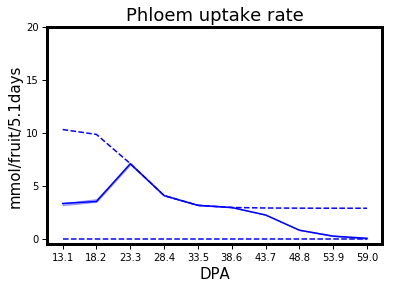

In [68]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

templist = list()
templist2 = list()
templist3 = list()
xlist = list()
error_min = list()
error_max = list()
error_min2 = list()
error_max2 = list()
upper_limit = list()
for i in range(1,11):
    xlist.append(i)
    upper_limit.append(cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound)
    templist.append(solution2.x_dict["Phloem_uptake_tx"+str(i)])
    templist2.append(temp_solution.x_dict["Phloem_uptake_tx"+str(i)])
    error_max.append(abs(cobra_model6.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min.append(abs(cobra_model6.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
    error_max2.append(abs(cobra_model7.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min2.append(abs(cobra_model7.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
plt.plot(xlist,templist,"-",color="blue",label="phloem uptake when constrained")
plt.plot(xlist,upper_limit,"--",color="blue")
plt.plot(xlist,[0]*len(xlist),"--",color="blue",label="phloem uptake constraint")
plt.fill_between(xlist,error_max,error_min,alpha=0.3,color="blue")

plt.title("Phloem uptake rate")
plt.ylim(-0.5,20)
plt.yticks(fontsize=10)
plt.xticks(xlist,DPA[1:],fontsize=10)
plt.xlabel("DPA")
plt.ylabel("mmol/fruit/5.1days")
plt.show()


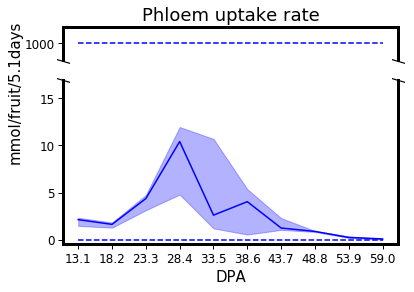

In [69]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig=plt.subplots(sharex=True)
gs = gridspec.GridSpec(2,1,height_ratios=[1,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

templist = list()
templist2 = list()
templist3 = list()
xlist = list()
error_min = list()
error_max = list()
error_min2 = list()
error_max2 = list()
upper_limit = list()
for i in range(1,11):
    xlist.append(i)
    upper_limit.append(cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound)
    templist.append(solution2.x_dict["Phloem_uptake_tx"+str(i)])
    templist2.append(temp_solution.x_dict["Phloem_uptake_tx"+str(i)])
    error_max.append(abs(cobra_model6.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min.append(abs(cobra_model6.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
    error_max2.append(abs(cobra_model7.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min2.append(abs(cobra_model7.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
    
ax1.plot(xlist,templist2,"-",label="Phloem uptake when unconstrained",color="blue")
ax1.fill_between(xlist,error_max2,error_min2,alpha=0.3,color="blue")
ax0.plot(xlist,[1000]*len(xlist),"--",color="blue")
ax1.plot(xlist,[0]*len(xlist),"--",color="blue",label="phloem uptake constraint")


ax0.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax0.tick_params(bottom=False,labelbottom=False)
ax1.tick_params(top=False)
ax0.set_ylim(990,1010)
ax0.set_yticks([1000])
ax1.set_ylim(-0.5,17)


ax0.set_title("Phloem uptake rate")
#plt.ylim(-0.5,4.5)
#plt.yticks(fontsize=10)
plt.xticks(xlist,DPA[1:],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("DPA")
plt.text(-1.1,22,"mmol/fruit/5.1days",rotation=90)
plt.text(0.4,16,"/",rotation=90)
plt.text(10.3,16,"/",rotation=90)
plt.text(0.4,18,"/",rotation=90)
plt.text(10.3,18,"/",rotation=90)
ax0.tick_params(axis='both', which='major', labelsize=12)
plt.show()


### Write flux distribution to file

In [70]:
writeSolutionFluxesToFile(solution2,"FruitFluxes.csv",cobra_model2)

---

### Osmoles

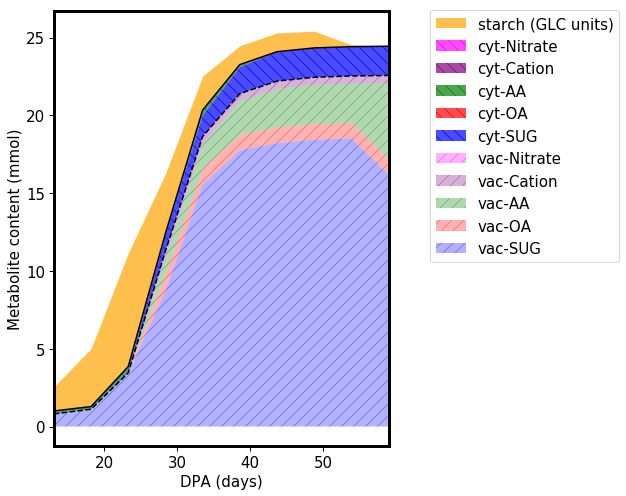

In [129]:
SOL = solution2

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.x_dict.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.x_dict.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.x_dict.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.x_dict.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.x_dict.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.x_dict.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.x_dict.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.x_dict.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.x_dict.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.x_dict.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.x_dict.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.x_dict.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.x_dict.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.x_dict.get(rxn.id)
        else:
            y12 = y12 + SOL.x_dict.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.x_dict.get(rxn.id)
        else:
            y13 = y13 + SOL.x_dict.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.x_dict.get(rxn.id)
        else:
            y14 = y14 + SOL.x_dict.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC units)",linewidth=0)

handles, labels = plt.gca().get_legend_handles_labels()
labels.reverse()
handles.reverse()
lgd=plt.legend(handles,labels,bbox_to_anchor=(1.1, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Phytol and Lycopene constraints added

In [71]:
temp_model = cobra_model2.copy()

df = pandas.read_csv("/home/sanu/JoseConc.csv",delimiter="\t")
DPA = list(df.DPA)

for i in range(1,11):
    rxn = temp_model.reactions.get_by_id("Lycopene_biomass_demand_tx"+str(i))
    rxn.lower_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)       #mmol/fruit/5.1day
    rxn.upper_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)       #mmol/fruit/5.1day
    rxn = temp_model.reactions.get_by_id("Phytol_biomass_demand_tx"+str(i))
    rxn.lower_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day
    rxn.upper_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day

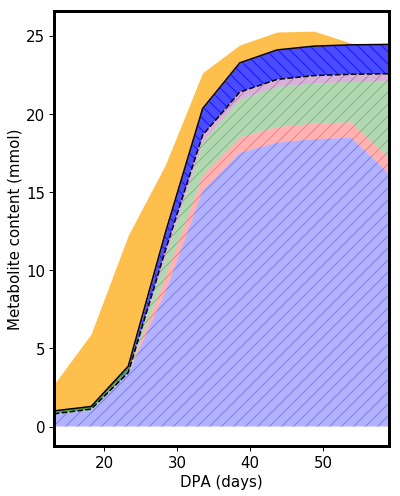

In [72]:
SOLtemp = pfba_Weighted(temp_model,weightings)
SOL = SOLtemp

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.x_dict.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.x_dict.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.x_dict.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.x_dict.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.x_dict.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.x_dict.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.x_dict.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.x_dict.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.x_dict.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.x_dict.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.x_dict.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.x_dict.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.x_dict.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.x_dict.get(rxn.id)
        else:
            y12 = y12 + SOL.x_dict.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.x_dict.get(rxn.id)
        else:
            y13 = y13 + SOL.x_dict.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.x_dict.get(rxn.id)
        else:
            y14 = y14 + SOL.x_dict.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Phloem uptake constraint removed

In [135]:
temp_model2 = temp_model.copy()
for i in range(1,11):
    temp_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000
    temp_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0

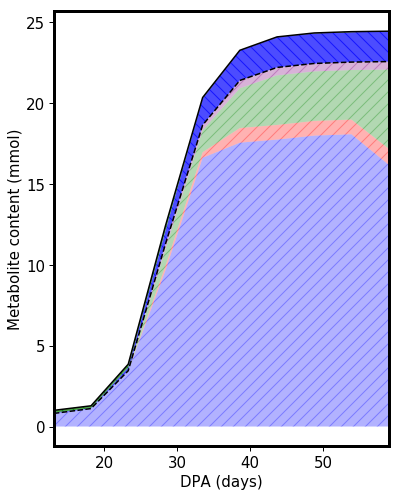

In [136]:
SOL = pfba_Weighted(temp_model2,weightings)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.x_dict.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.x_dict.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.x_dict.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.x_dict.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.x_dict.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.x_dict.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.x_dict.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.x_dict.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.x_dict.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.x_dict.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.x_dict.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.x_dict.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.x_dict.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.x_dict.get(rxn.id)
        else:
            y12 = y12 + SOL.x_dict.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.x_dict.get(rxn.id)
        else:
            y13 = y13 + SOL.x_dict.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.x_dict.get(rxn.id)
        else:
            y14 = y14 + SOL.x_dict.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Phloem uptake and osmolarity constraint removed

In [137]:
temp_model3 = temp_model2.copy()
for i in range(1,11):
    temp_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000
    temp_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    temp_model3.metabolites.get_by_id("VO_"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CO_"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CC_v"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CC_c"+str(i)).remove_from_model()

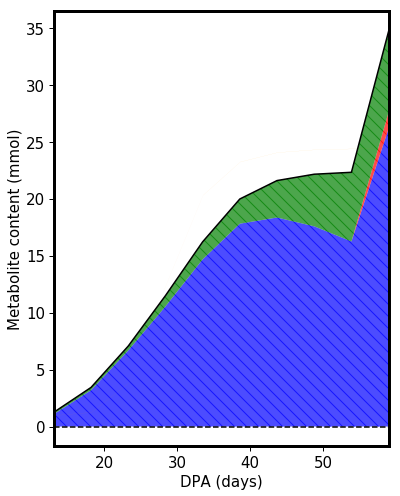

In [138]:
SOL = pfba_Weighted(temp_model3,weightings)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.x_dict.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.x_dict.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.x_dict.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.x_dict.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.x_dict.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.x_dict.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.x_dict.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.x_dict.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.x_dict.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.x_dict.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.x_dict.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.x_dict.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.x_dict.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.x_dict.get(rxn.id)
        else:
            y12 = y12 + SOL.x_dict.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.x_dict.get(rxn.id)
        else:
            y13 = y13 + SOL.x_dict.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.x_dict.get(rxn.id)
        else:
            y14 = y14 + SOL.x_dict.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Removing biomass constraints

In [200]:
tempList[0:4]+tempList[5:6]+tempList[8:9]+tempList[10:13]

['MET_c',
 'THR_c',
 'HIS_c',
 'LYS_c',
 'CYS_c',
 'SER_c',
 'GLT_c',
 'ARG_c',
 'L_ALPHA_ALANINE_c']

In [199]:
temp_model4 = temp_model3.copy()
for i in range(1,11):
    rxn = temp_model3.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model3.reactions.get_by_id("phospholipid_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model3.reactions.get_by_id("CELLULOSE_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0

tempList = list()
for met in temp_model4.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if "PROTON" in met.id or "SUCROSE" in met.id or "GLC" in met.id or "FRU" in met.id:
        continue
    tempList.append(met.id[0:len(met.id)-1])
    
for Met in tempList[0:4]+tempList[5:6]+tempList[8:9]+tempList[10:13]:
    for i in range(1,11):
        met = temp_model4.metabolites.get_by_id(Met+str(i))
        rxn = temp_model4.reactions.get_by_id("Phloem_uptake_tx"+str(i))
        coeff = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-1*coeff})

SOL = pfba_Weighted(temp_model4,weightings)
print(SOL.f)

140980.096394


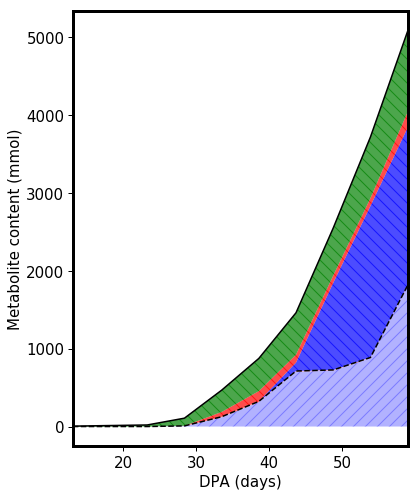

In [201]:
SOL = pfba_Weighted(temp_model4,weightings)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.x_dict.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.x_dict.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.x_dict.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.x_dict.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.x_dict.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.x_dict.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.x_dict.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.x_dict.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.x_dict.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.x_dict.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.x_dict.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.x_dict.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.x_dict.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.x_dict.get(rxn.id)
        else:
            y12 = y12 + SOL.x_dict.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.x_dict.get(rxn.id)
        else:
            y13 = y13 + SOL.x_dict.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.x_dict.get(rxn.id)
        else:
            y14 = y14 + SOL.x_dict.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Removing biomass constraints in system with osmotic constraints

In [202]:
temp_model5 = temp_model2.copy()
for i in range(1,11):
    rxn = temp_model2.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model2.reactions.get_by_id("phospholipid_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model2.reactions.get_by_id("CELLULOSE_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0

tempList = list()
for met in temp_model5.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if "PROTON" in met.id or "SUCROSE" in met.id or "GLC" in met.id or "FRU" in met.id:
        continue
    tempList.append(met.id[0:len(met.id)-1])
    
for Met in tempList[0:4]+tempList[5:6]+tempList[8:9]+tempList[10:13]:
    for i in range(1,11):
        met = temp_model5.metabolites.get_by_id(Met+str(i))
        rxn = temp_model5.reactions.get_by_id("Phloem_uptake_tx"+str(i))
        coeff = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-1*coeff})

SOL = pfba_Weighted(temp_model5,weightings)
print(SOL.f)

3692.56309058


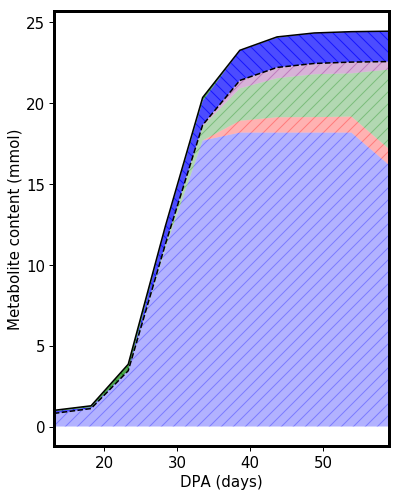

In [203]:
SOL = pfba_Weighted(temp_model5,weightings)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.x_dict.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.x_dict.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.x_dict.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.x_dict.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.x_dict.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.x_dict.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.x_dict.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.x_dict.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.x_dict.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.x_dict.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.x_dict.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.x_dict.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.x_dict.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.x_dict.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.x_dict.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.x_dict.get(rxn.id)
        else:
            y12 = y12 + SOL.x_dict.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.x_dict.get(rxn.id)
        else:
            y13 = y13 + SOL.x_dict.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.x_dict.get(rxn.id)
        else:
            y14 = y14 + SOL.x_dict.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()